# Modeling & Evaluation

This notebook trains and evaluates machine learning models for predicting **patient appointment no-shows**.

Focus:
- Strong baseline models
- Healthcare-relevant metrics
- Clear interpretation of results

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

## Load Engineered Dataset

In [2]:
# Load raw data
df = pd.read_csv("../data/raw/KaggleV2-May-2016.csv")

# Target
df['no_show'] = df['No-show'].map({'No': 0, 'Yes': 1})

# Dates
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

# Days between scheduling and appointment
df['days_between'] = (
    df['AppointmentDay'].dt.normalize()
    - df['ScheduledDay'].dt.normalize()
).dt.days
# Remove rows with negative days_between
removed = (df['days_between'] < 0).sum()
print(f"Rows with negative days_between removed: {removed}")
df = df[df['days_between'] >= 0]

df['appointment_weekday'] = df['AppointmentDay'].dt.weekday
df['is_weekend'] = df['appointment_weekday'].isin([5, 6]).astype(int)

# Demographics
df['gender'] = df['Gender'].map({'F': 0, 'M': 1})
df.loc[df['Age'] < 0, 'Age'] = np.nan

# Neighborhood frequency encoding
neighborhood_freq = df['Neighbourhood'].value_counts(normalize=True)
df['neighborhood_freq'] = df['Neighbourhood'].map(neighborhood_freq)

feature_cols = [
    'Age', 'gender', 'days_between', 'appointment_weekday', 'is_weekend',
    'SMS_received', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap',
    'neighborhood_freq'
]

df = df.dropna(subset=feature_cols)

X = df[feature_cols]
y = df['no_show']

X.head()

X.isna().sum()

Rows with negative days_between removed: 5


Age                    0
gender                 0
days_between           0
appointment_weekday    0
is_weekend             0
SMS_received           0
Hipertension           0
Diabetes               0
Alcoholism             0
Handcap                0
neighborhood_freq      0
dtype: int64

## Train / Validation Split

- Stratified split to preserve no-show ratio
- 80% train / 20% validation

In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train target distribution:\n", y_train.value_counts(normalize=True))
print("Validation target distribution:\n", y_val.value_counts(normalize=True))

Train target distribution:
 no_show
0    0.798102
1    0.201898
Name: proportion, dtype: float64
Validation target distribution:
 no_show
0    0.7981
1    0.2019
Name: proportion, dtype: float64


## Baseline Model — Logistic Regression

Why Logistic Regression?
- Interpretable
- Strong baseline
- Works well with structured healthcare data

In [4]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Logistic Regression with class weight
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_val_scaled)
y_prob_lr = log_reg.predict_proba(X_val_scaled)[:, 1]

In [5]:
print("Logistic Regression Classification Report")
print(classification_report(y_val, y_pred_lr))

print("ROC-AUC:", roc_auc_score(y_val, y_prob_lr))

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.86      0.69      0.76     17642
           1       0.31      0.56      0.40      4463

    accuracy                           0.66     22105
   macro avg       0.59      0.62      0.58     22105
weighted avg       0.75      0.66      0.69     22105

ROC-AUC: 0.6646673121804664


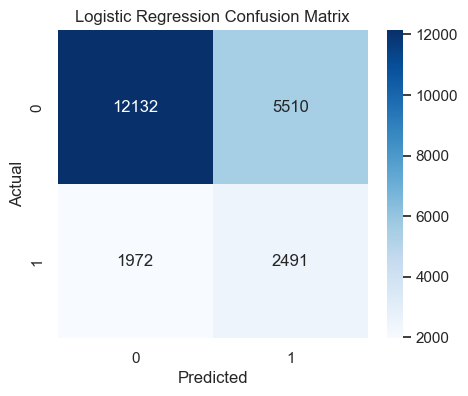

In [6]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_lr)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

## Random Forest Model

Why Random Forest?
- Captures non-linear patterns
- Handles feature interactions
- Strong performance on tabular data

In [7]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)
y_prob_rf = rf.predict_proba(X_val)[:, 1]

print("Random Forest (Balance weights) Classification Report")
print(classification_report(y_val, y_pred_rf))

print("ROC-AUC:", roc_auc_score(y_val, y_prob_rf))

Random Forest (Balance weights) Classification Report
              precision    recall  f1-score   support

           0       0.92      0.54      0.68     17642
           1       0.31      0.81      0.45      4463

    accuracy                           0.59     22105
   macro avg       0.61      0.67      0.56     22105
weighted avg       0.79      0.59      0.63     22105

ROC-AUC: 0.7262634098658958


In [8]:
print("Random Forest Classification Report")
print(classification_report(y_val, y_pred_rf))

print("ROC-AUC:", roc_auc_score(y_val, y_prob_rf))

Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.92      0.54      0.68     17642
           1       0.31      0.81      0.45      4463

    accuracy                           0.59     22105
   macro avg       0.61      0.67      0.56     22105
weighted avg       0.79      0.59      0.63     22105

ROC-AUC: 0.7262634098658958


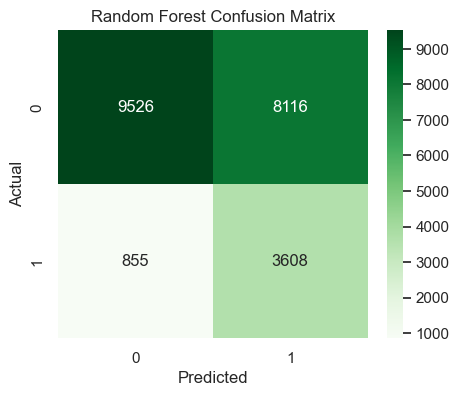

In [9]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

## ROC Curve Comparison

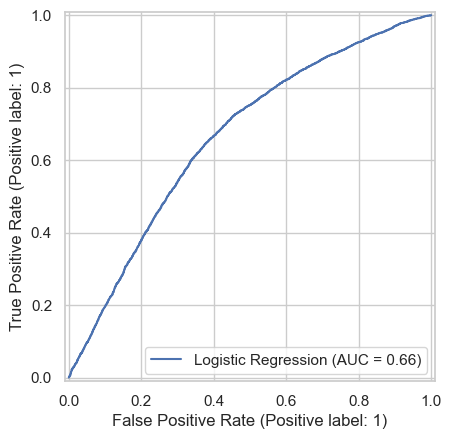

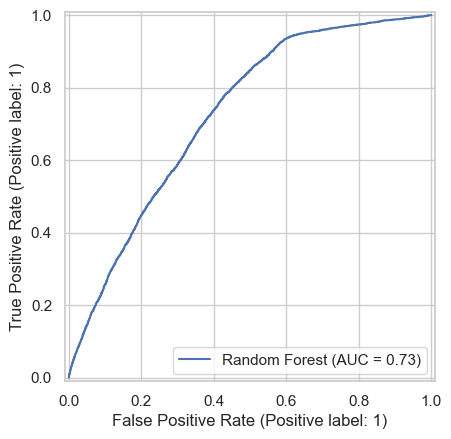

In [10]:
RocCurveDisplay.from_predictions(y_val, y_prob_lr, name="Logistic Regression")
RocCurveDisplay.from_predictions(y_val, y_prob_rf, name="Random Forest")
plt.show()

# Healthcare Interpretation

- **Recall for no-show (class 1)** is critical
- False negatives = missed opportunity to intervene
- False positives = extra reminders (low cost)

**Therefore, recall > precision is acceptable.**

The Random Forest model successfully identifies the majority of no-show patients (81% recall), which enables proactive scheduling interventions. Although precision is low, the cost of false positives (sending reminders or follow-ups) is significantly lower than the cost of missed appointments.